In [49]:
from PIL import Image
from tqdm import tqdm
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize

#이미지 불러오기

train_path = 'C:/MLDL/crop_train_result/slough/'
mask_path = 'C:/MLDL/crop_train_mask_result/slough/'

train_list = os.listdir(train_path)
mask_list = os.listdir(mask_path)
#X를 uint8로 해야하나
X = np.zeros((len(train_list), 31,31, 3), dtype=np.uint8)
Y = np.zeros((len(mask_list), 31,31, 1), dtype=np.bool)

for n, name in tqdm(enumerate(train_list), total=len(train_list)):
    path = train_path + name
    img = imread(path)
    img = resize(img, output_shape=(31,31,3), preserve_range=True)
    X[n]=np.array(img)

for n, maskname in tqdm(enumerate(mask_list), total = len(mask_list)):
#for n, maskname in enumerate(mask_list):
    path = mask_path + maskname
    mask=imread(path,as_gray=True)
    mask = resize(mask, output_shape=(31,31,1), preserve_range=True)
    Y[n] = np.array(mask)
    
    
    
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1)
savepath='C:/MLDL/npy/slough/'
np.save(savepath+'x_train_slough', x_train)
np.save(savepath+'y_train_slough', y_train)
np.save(savepath+'x_val_slough', x_val)
np.save(savepath+'y_val_slough', y_val)

100%|███████████████████████████████████████████████████████████████████████████████| 616/616 [00:03<00:00, 204.77it/s]


In [50]:
import numpy as np
x_train=np.load('C:/MLDL/npy/slough/x_train_slough.npy')/255.
y_train=np.load('C:/MLDL/npy/slough/y_train_slough.npy')
x_val=np.load('C:/MLDL/npy/slough/x_val_slough.npy')/255.
y_val=np.load('C:/MLDL/npy/slough/y_val_slough.npy')

In [66]:
print(x_train.shape,x_val.shape)

(554, 31, 31, 3) (62, 31, 31, 3)


In [51]:
#sigmoid
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (5,5),strides=(2,2), activation='relu', input_shape=(31, 31, 3)), 
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2,2),activation='relu'),
    tf.keras.layers.Conv2D(64,(5, 5),strides=(2,2), activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, (5, 5),strides=(2,2)),
    tf.keras.layers.Conv2DTranspose(32, (6, 6),strides=(2,2)),
    tf.keras.layers.Conv2DTranspose(16, (5, 5),strides=(2,2)),
    tf.keras.layers.Conv2D(1, 1,strides=1,activation='sigmoid')
                

])

model.summary()




Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 14, 14, 16)        1216      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 5, 5, 32)          12832     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 1, 64)          51264     
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 5, 5, 64)          102464    
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 14, 14, 32)        73760     
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 31, 31, 16)        12816     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 31, 1)        

In [52]:
model.compile(optimizer='adam' #decay0.0001, momentum 0.9?
              , loss='binary_crossentropy'
              , metrics=[tf.keras.metrics.MeanIoU(num_classes=2), 'accuracy'])

In [53]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
callback_param = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='auto', min_lr=1e-05)

history = model.fit(x_train, y_train
                    , validation_data=(x_val, y_val)
                    , epochs=100, batch_size=100
                    , callbacks=[callback_param]
                    )

Epoch 1/100
6/6 [==============================] - 2s 340ms/step - loss: 0.6826 - mean_io_u_6: 0.3377 - accuracy: 0.6456 - val_loss: 0.6398 - val_mean_io_u_6: 0.3291 - val_accuracy: 0.6583
Epoch 2/100
6/6 [==============================] - 1s 178ms/step - loss: 0.6327 - mean_io_u_6: 0.3377 - accuracy: 0.6754 - val_loss: 0.6240 - val_mean_io_u_6: 0.3291 - val_accuracy: 0.6583
Epoch 3/100
6/6 [==============================] - 1s 154ms/step - loss: 0.6089 - mean_io_u_6: 0.3377 - accuracy: 0.6754 - val_loss: 0.6108 - val_mean_io_u_6: 0.3291 - val_accuracy: 0.6580
Epoch 4/100
6/6 [==============================] - 1s 166ms/step - loss: 0.5989 - mean_io_u_6: 0.3377 - accuracy: 0.6743 - val_loss: 0.6026 - val_mean_io_u_6: 0.3291 - val_accuracy: 0.6588
Epoch 5/100
6/6 [==============================] - 1s 182ms/step - loss: 0.5823 - mean_io_u_6: 0.3377 - accuracy: 0.6754 - val_loss: 0.6109 - val_mean_io_u_6: 0.3291 - val_accuracy: 0.6586
Epoch 6/100
6/6 [==============================] - 1s 1

6/6 [==============================] - 1s 169ms/step - loss: 0.2146 - mean_io_u_6: 0.3377 - accuracy: 0.9126 - val_loss: 0.5593 - val_mean_io_u_6: 0.3291 - val_accuracy: 0.7572
Epoch 81/100
6/6 [==============================] - 1s 187ms/step - loss: 0.2142 - mean_io_u_6: 0.3377 - accuracy: 0.9129 - val_loss: 0.5598 - val_mean_io_u_6: 0.3291 - val_accuracy: 0.7567
Epoch 82/100
6/6 [==============================] - 1s 168ms/step - loss: 0.2140 - mean_io_u_6: 0.3377 - accuracy: 0.9130 - val_loss: 0.5602 - val_mean_io_u_6: 0.3291 - val_accuracy: 0.7566
Epoch 83/100
6/6 [==============================] - 1s 163ms/step - loss: 0.2137 - mean_io_u_6: 0.3377 - accuracy: 0.9131 - val_loss: 0.5614 - val_mean_io_u_6: 0.3291 - val_accuracy: 0.7570
Epoch 84/100
6/6 [==============================] - 1s 163ms/step - loss: 0.2134 - mean_io_u_6: 0.3377 - accuracy: 0.9134 - val_loss: 0.5629 - val_mean_io_u_6: 0.3291 - val_accuracy: 0.7570
Epoch 85/100
6/6 [==============================] - 1s 249ms/st

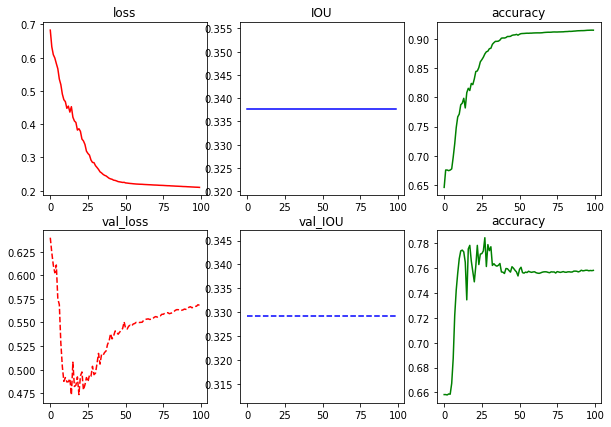

In [54]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('IOU')
ax[0, 1].plot(history.history['mean_io_u_6'], 'b')
ax[0, 2].set_title('accuracy')
ax[0, 2].plot(history.history['accuracy'], 'g')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_IOU')
ax[1, 1].plot(history.history['val_mean_io_u_6'], 'b--')
ax[1, 2].set_title('accuracy')
ax[1, 2].plot(history.history['val_accuracy'], 'g')

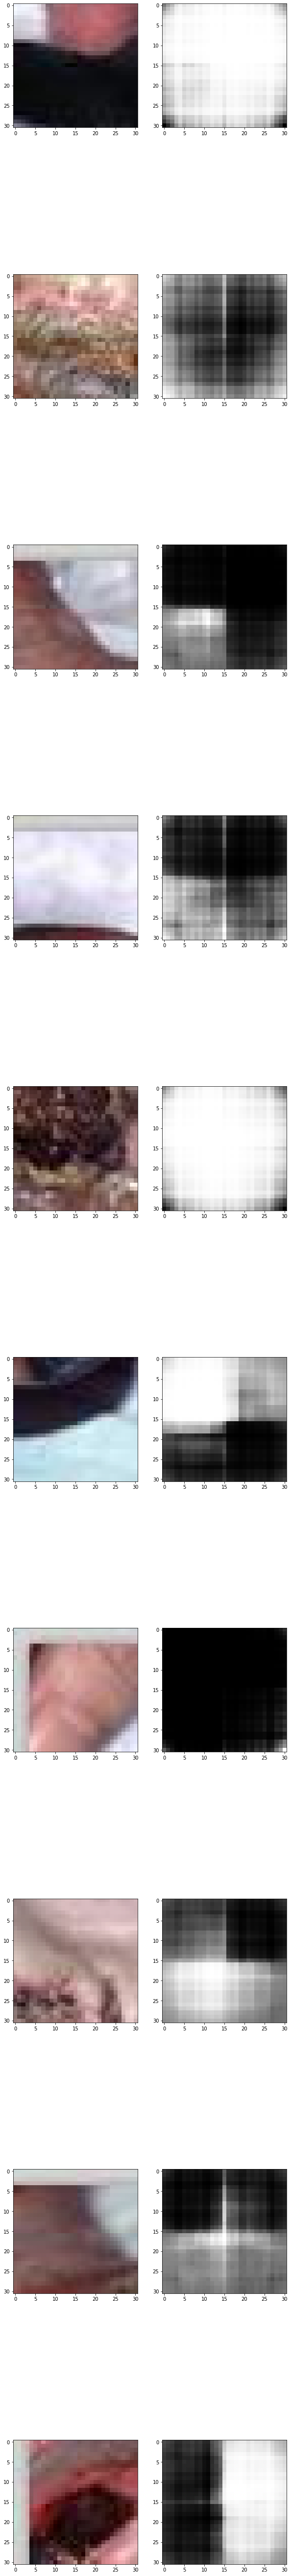

In [55]:
preds_val = model.predict(x_val[:10])

fig, ax = plt.subplots(len(preds_val), 2, figsize=(10, 100))

for i, pred in enumerate(preds_val):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    #ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(pred.squeeze(), cmap='gray')

In [65]:


#이미지 불러오기

test_path = 'C:/MLDL/crop_test_result/slough/'
testmask_path = 'C:/MLDL/crop_test_mask_result/slough/'
test_list = os.listdir(test_path)
testmask_list = os.listdir(testmask_path)
#X를 uint8로 해야하나
X = np.zeros((len(test_list), 31,31, 3), dtype=np.uint8)
Y = np.zeros((len(testmask_list), 31,31, 1), dtype=np.bool)

for n, name in tqdm(enumerate(test_list), total=len(test_list)):
    path = test_path + name
    img = imread(path)
    img = resize(img, output_shape=(31,31,3), preserve_range=True)
    X[n]=np.array(img)

for n, maskname in tqdm(enumerate(testmask_list), total = len(testmask_list)):
#for n, maskname in enumerate(mask_list):
    path = testmask_path + maskname
    mask=imread(path,as_gray=True)
    mask = resize(mask, output_shape=(31,31,1), preserve_range=True)
    Y[n] = np.array(mask)
    
    

savepath='C:/MLDL/npy_test/slough/'
np.save(savepath+'x_test_slough', X)
np.save(savepath+'y_test_slough', Y)

100%|█████████████████████████████████████████████████████████████████████████████| 2034/2034 [00:10<00:00, 194.49it/s]


In [57]:
import numpy as np
x_test_slough=np.load('C:/MLDL/npy_test/slough/x_test_slough.npy')/255.
y_test_slough=np.load('C:/MLDL/npy_test/slough/y_test_slough.npy')


In [58]:
evaluation = model.evaluate(x_test_slough,y_test_slough, batch_size=10)

204/204 [==============================] - 2s 12ms/step - loss: 0.9052 - mean_io_u_6: 0.3178 - accuracy: 0.6418


In [59]:
preds = model.predict(x_test_slough)
preds[preds>=0.5] = 1
preds[preds<0.5]=0

(array([54.73465263,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

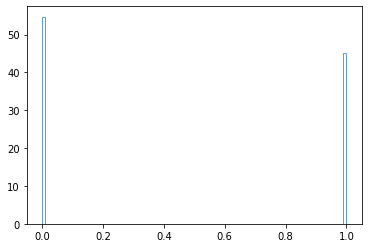

In [60]:
#prediction 값 분포를 보고 threshold 정하기
plt.hist(np.ravel(preds[0], order='C'), bins=100, density=True, alpha=0.7, histtype='step')

In [61]:
m=tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(y_test,preds)
print(m.result())

tf.Tensor(0.45921174, shape=(), dtype=float32)


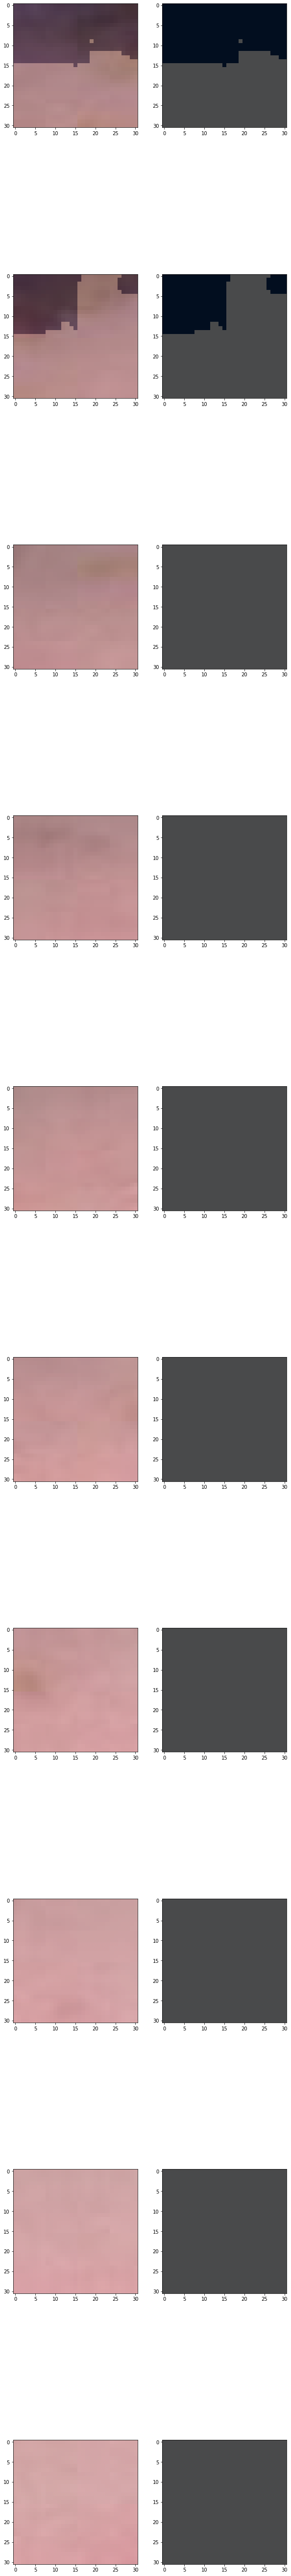

In [64]:
kernel = np.ones((5,5),np.uint8)
fig, ax = plt.subplots(len(x_test[0:10]), 2, figsize=(10, 100))

for i, pred in enumerate(preds[0:10]):
    ax[i, 0].imshow(x_test[i].squeeze(), cmap='gray')
    ax[i, 0].imshow(pred.squeeze(), cmap='Blues', alpha=0.3)
    ax[i, 1].imshow(y_test[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(pred.squeeze(), cmap='Blues', alpha=0.3)
  

In [14]:
import numpy as np
x=np.load('C:/Users/박신영/Desktop/2학기/머신러닝과 딥러닝/프로젝트 논문/npy1106/X.npy')/255.
y=np.load('C:/Users/박신영/Desktop/2학기/머신러닝과 딥러닝/프로젝트 논문/npy1106/Y.npy')
print(x.shape,y.shape)

(2090, 128, 128, 3) (2090, 128, 128, 1)


In [15]:
#granulation, slough, necrosis
def datacutter(data, l0, l1, l2):
  train0 = data[:l0,]
  train1 = data[l0:l0+l1,]
  train2 = data[l1:l1+l2,]
  return train0, train1, train2

In [16]:
l0=730; l1=510; l2=850
x_train0, x_train1, x_train2 = datacutter(x, l0, l1, l2)
y_train0, y_train1, y_train2 = datacutter(y, l0, l1, l2)
print(x_train0.shape, x_train1.shape, x_train2.shape)
print(y_train0.shape, y_train1.shape, y_train2.shape)

(730, 128, 128, 3) (510, 128, 128, 3) (850, 128, 128, 3)
(730, 128, 128, 1) (510, 128, 128, 1) (850, 128, 128, 1)


In [17]:
#granulation
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train0,y_train0, test_size=0.1, random_state=1004)

In [21]:
#sigmoid
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (31,31),strides=(2,2), activation='relu', input_shape=(128, 128, 3)), 
    tf.keras.layers.Conv2D(32, (5, 5), strides=(2,2),activation='relu'),
    tf.keras.layers.Conv2D(64,(5, 5),strides=(2,2), activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, (5, 5),strides=(2,2)),
    tf.keras.layers.Conv2DTranspose(32, (5, 5),strides=(2,2)),
    tf.keras.layers.Conv2DTranspose(16, (32, 32),strides=(2,2)),
    tf.keras.layers.Conv2D(1, 1,strides=1,activation='sigmoid')
                
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 49, 49, 16)        46144     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 23, 23, 32)        12832     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 64)        51264     
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 23, 23, 64)        102464    
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 49, 49, 32)        51232     
_________________________________________________________________
conv2d_transpose_17 (Conv2DT (None, 128, 128, 16)      524304    
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, 128, 1)      

In [25]:
mIOU=tf.keras.metrics.MeanIoU(num_classes=2)
model.compile(optimizer='adam' #decay0.0001, momentum 0.9?
              , loss='binary_crossentropy'
              , metrics=[mIOU, 'accuracy'])

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
callback_param = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1, mode='auto', min_lr=1e-05)

history = model.fit(x_train, y_train
                    , validation_data=(x_val, y_val)
                    , epochs=10, batch_size=40
                    , callbacks=[callback_param]
                    )

Epoch 1/10
17/17 [==============================] - 505s 30s/step - loss: 0.4034 - mean_io_u_3: 0.4242 - accuracy: 0.8569 - val_loss: 0.3318 - val_mean_io_u_3: 0.4229 - val_accuracy: 0.8764
Epoch 2/10
17/17 [==============================] - 403s 24s/step - loss: 0.3373 - mean_io_u_3: 0.4242 - accuracy: 0.8615 - val_loss: 0.3256 - val_mean_io_u_3: 0.4229 - val_accuracy: 0.8767
Epoch 3/10
17/17 [==============================] - 401s 24s/step - loss: 0.3272 - mean_io_u_3: 0.4242 - accuracy: 0.8673 - val_loss: 0.3282 - val_mean_io_u_3: 0.4229 - val_accuracy: 0.8471
Epoch 4/10
17/17 [==============================] - 523s 31s/step - loss: 0.3172 - mean_io_u_3: 0.4242 - accuracy: 0.8703 - val_loss: 0.3053 - val_mean_io_u_3: 0.4229 - val_accuracy: 0.8742
Epoch 5/10
17/17 [==============================] - 409s 24s/step - loss: 0.3087 - mean_io_u_3: 0.4242 - accuracy: 0.8738 - val_loss: 0.3154 - val_mean_io_u_3: 0.4229 - val_accuracy: 0.8523
Epoch 6/10
17/17 [==============================] 

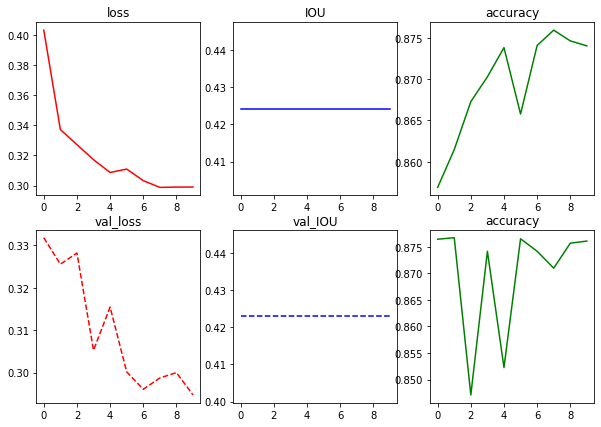

In [27]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('IOU')
ax[0, 1].plot(history.history['mean_io_u_3'], 'b')
ax[0, 2].set_title('accuracy')
ax[0, 2].plot(history.history['accuracy'], 'g')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_IOU')
ax[1, 1].plot(history.history['val_mean_io_u_3'], 'b--')
ax[1, 2].set_title('accuracy')
ax[1, 2].plot(history.history['val_accuracy'], 'g')

In [34]:
evaluation = model.evaluate(x_test0[0:1],y_test0[0:1], batch_size=10)

1/1 [==============================] - 0s 5ms/step - loss: 0.2043 - mean_io_u_3: 0.4365 - accuracy: 0.9197


In [30]:
preds = model.predict(x_test)
preds[preds>=0.5] = 1
preds[preds<0.5]=0

(array([90.93017781,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

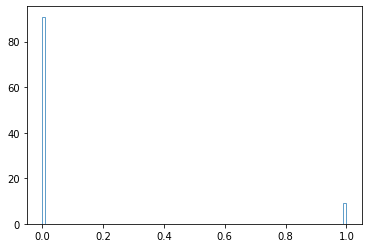

In [31]:
#prediction 값 분포를 보고 threshold 정하기
plt.hist(np.ravel(preds[0], order='C'), bins=100, density=True, alpha=0.7, histtype='step')

In [35]:
m=tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(y_test,preds)
print(m.result())

tf.Tensor(0.51776546, shape=(), dtype=float32)


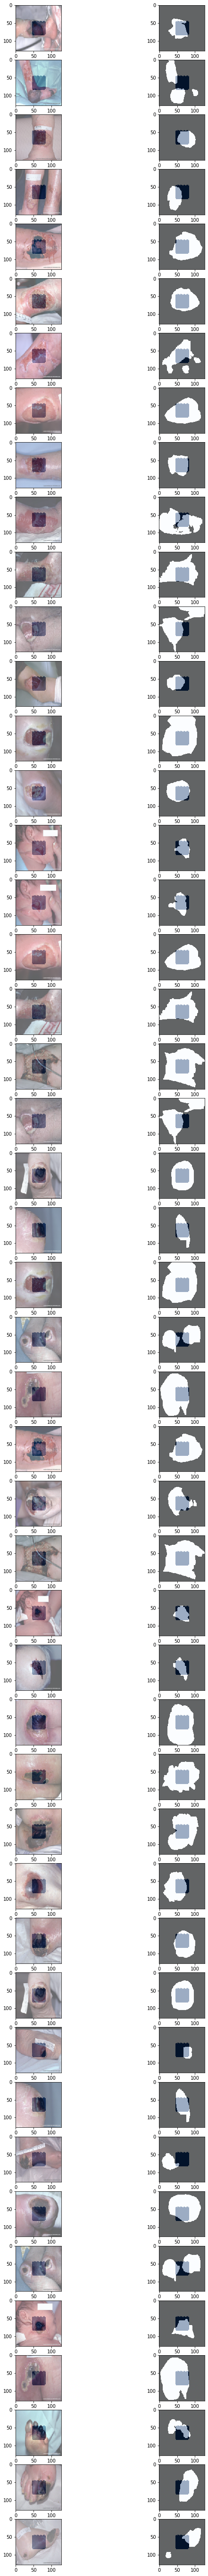

In [36]:
kernel = np.ones((5,5),np.uint8)
fig, ax = plt.subplots(len(x_test), 2, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_test[i].squeeze(), cmap='gray')
    ax[i, 0].imshow(pred.squeeze(), cmap='Blues', alpha=0.4)
    ax[i, 1].imshow(y_test[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(pred.squeeze(), cmap='Blues', alpha=0.4)